Need to clone lsst/throughputs and setenv THROUGHPUTS_DIR to point to that directory first.

In [1]:
from collections import OrderedDict as odict

import sncosmo
import analyzeSN as ans

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Comparison of model and simulated data
We already know how to extract the data from the simulations. The data is the model light curve + noise. The model used here is SALT2, which has a few parameters ['x0', 'x1', 'c', 'z', 't0']. We must estimate the values of these parameters from the data

In [2]:
simdata = ans.SNANASims.fromSNANAfileroot('LSST_Ia', location='ENIGMA_LSSTMAIN/', coerce_inds2int=False)
print simdata.headData.shape

(1622, 78)


Find SNe with large numbers of observations (for demonstration)

In [3]:
nobs = [simdata.get_SNANA_photometry(snid=snid).lightCurve.shape[0] for snid in simdata.headData.index.values]

In [4]:
print np.array(nobs).max()
snid = simdata.headData.index.values[np.argmax(np.array(nobs))]
print snid

71
3942


In [5]:
#hd = simdata.headData.query('REDSHIFT_FINAL > 0.2 and REDSHIFT_FINAL < 0.25').head(5).copy()
hd = simdata.headData.query('NOBS > 50').head(5).copy()
#hd = simdata.headData.query('REDSHIFT_FINAL < 0.1').head(5).copy()
#snid = hd.index.values[2]
print snid
hd

3942


,IAUC,FAKE,RA,DECL,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,...,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y
SNID,,,,,,,,,,,,,,,,,,,,,
3942,NULL,2,0.000000,-0.794553,0.2,-9,-9,1,71,5757,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
14174,NULL,2,2.646689,-0.355408,0.2,-9,-9,1,51,20809,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [6]:
lcobj = simdata.get_SNANA_photometry(snid=snid)
print lcobj.lightCurve.shape
#lcobj.lightCurve

(71, 22)


In [7]:
print simdata.headData.ix[snid]
hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                                    SIM_SALT2x0='x0',
                                                                                    SIM_SALT2x1='x1',
                                                                                    SIM_SALT2c='c',
                                                                                    SIM_MWEBV='ebv',                                   
                                                                                    REDSHIFT_FINAL='z')).apply(odict, axis=1)

IAUC                      NULL    
FAKE                             2
RA                               0
DECL                     -0.794553
PIXSIZE                        0.2
NXPIX                           -9
NYPIX                           -9
SNTYPE                           1
NOBS                            71
PTROBS_MIN                    5757
PTROBS_MAX                    5827
MWEBV                         0.01
MWEBV_ERR                   0.0016
REDSHIFT_HELIO            0.774001
REDSHIFT_HELIO_ERR          0.0005
REDSHIFT_FINAL            0.771876
REDSHIFT_FINAL_ERR          0.0005
HOSTGAL_OBJID                12333
HOSTGAL_PHOTOZ            0.764214
HOSTGAL_PHOTOZ_ERR           0.014
HOSTGAL_SPECZ                    0
HOSTGAL_SPECZ_ERR                0
HOSTGAL_SNSEP                 -999
HOSTGAL_LOGMASS                 -9
HOSTGAL_LOGMASS_ERR             -9
HOSTGAL_MAG_u                  999
HOSTGAL_MAG_g                  999
HOSTGAL_MAG_r                  999
HOSTGAL_MAG_i       

In [8]:
hd['params'].ix[snid]

OrderedDict([('t0', 52534.863),
             ('x0', 3.3000356e-06),
             ('x1', 0.7941221),
             ('c', 0.042838477),
             ('z', 0.77187568)])

In [9]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                     effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
model.set(**hd.ix[snid].params)

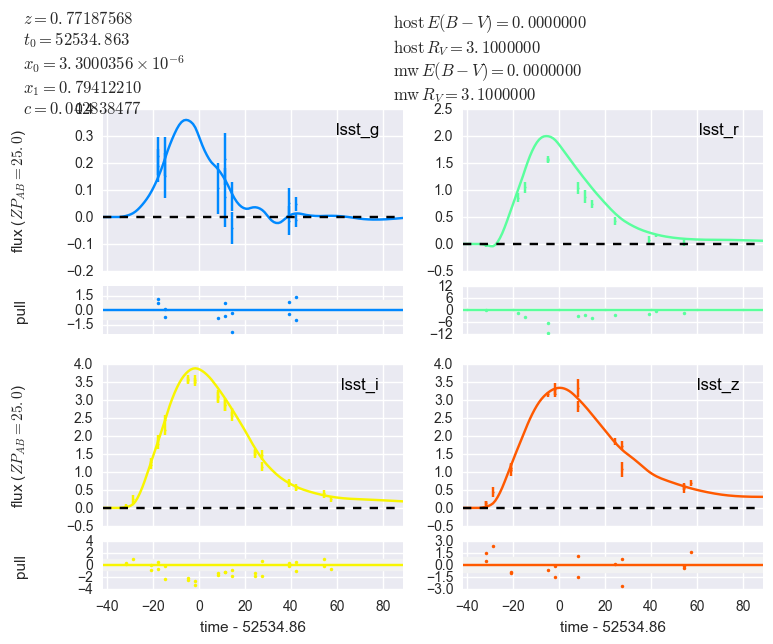

In [10]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)

### Inferring the model parameters from the data
First we will use a max likelihood method for estimating the model parameters

In [11]:
fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

In [12]:
print fitres[0].parameters
fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
fitresChar.parameters

[  7.71875679e-01   5.25347512e+04   3.04764759e-06   1.07643913e+00
   1.34850060e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]


z              0.771876
t0         52534.751241
x0             0.000003
x1             1.076439
c              0.134850
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [13]:
fitresChar.vparams

t0    52534.751241
x0        0.000003
x1        1.076439
c         0.134850
dtype: float64

In [14]:
fitresChar.salt_covariance_linear()

,mB,x1,c
mB,0.000675,0.001867,0.000261
x1,0.001867,0.030467,0.000616
c,0.000261,0.000616,0.001676


Errors on model parameters. Including mu.

In [15]:
fitresChar.mu_variance_linear()**0.5

0.12547566097161381

In [16]:
print fitresChar.sncosmoModel.parameters
print fitresChar.sncosmoModel.param_names
#??fitresChar.salt_covariance_linear

[  7.71875679e-01   5.25347512e+04   3.04764759e-06   1.07643913e+00
   1.34850060e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]
['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']


### Compute mu from model parameters. 

Notes from Rahul:
    
Yes the issue is with `mB` … the true SALT definition is it is the apparent mag in the BessellB rest frame band.

In the SALT model this turns out to be -2.5 log10(x0) + constant to a very good approximation.

Those numbers come from fitting a sample of SN  (real data) eg JLA.

In [17]:
def computeMu(fitresChar, alpha=0.14, beta=-3.11):
    # mu = alpha * x1 + beta * c + mB + const and set alpha = 0.14, beta = -3.11
    # mB = -2.5 log10(x0) ? (approximately)
    mB = -2.5 * np.log10(fitresChar.parameters['x0'])
    mu = alpha * fitresChar.parameters['x1'] + beta * fitresChar.parameters['c'] + mB #+ const
    return mu

In [18]:
computeMu(fitresChar)

13.521405927265747

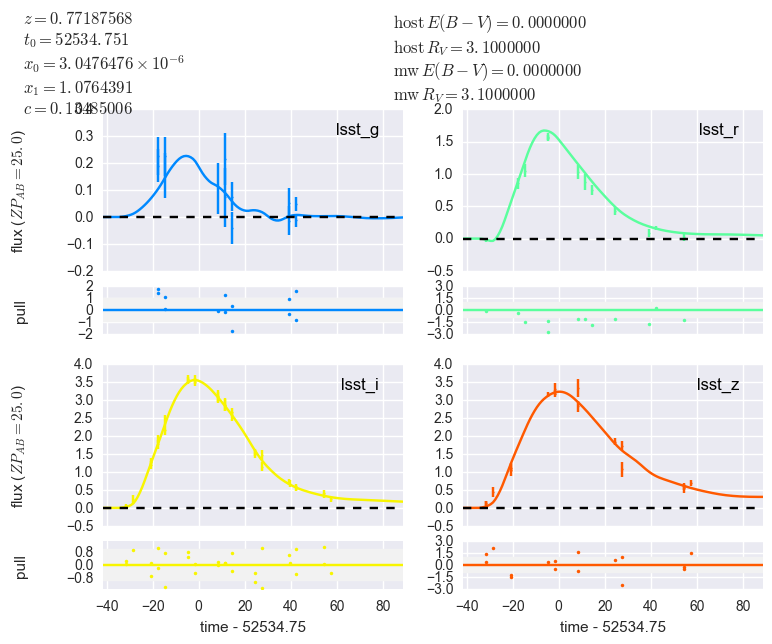

In [19]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar.sncosmoModel)

### What if we did not know z?

In [20]:
fitres_z = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c', 'z'], guess_z=True, 
                          bounds=dict(z=(0.65, 0.85)),
                          modelcov=True)

In [21]:
fitresChar_z = ans.ResChar.fromSNCosmoRes(fitres_z)
fitresChar_z.parameters

z              0.788165
t0         52534.978648
x0             0.000003
x1             1.086349
c              0.104184
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [22]:
fitresChar_z.mu_variance_linear()**0.5

0.15256949143594684

13.6186339542


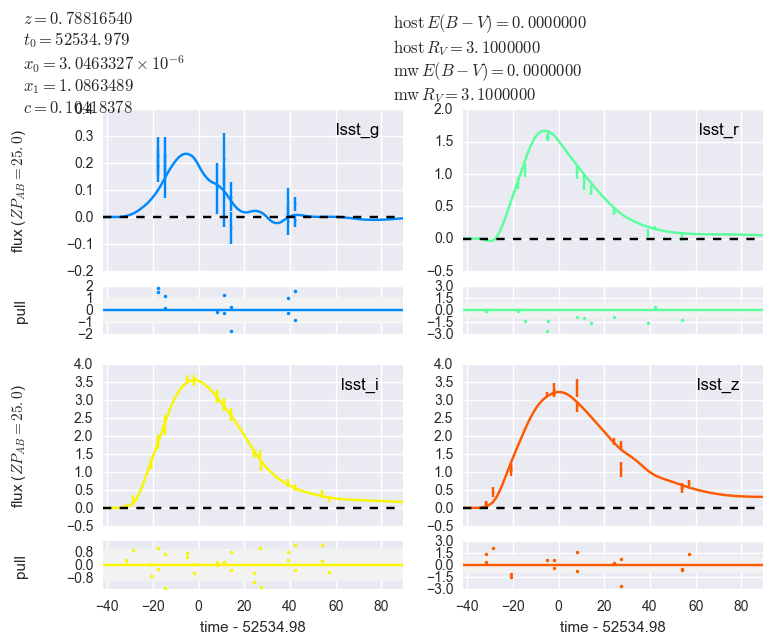

In [23]:
print computeMu(fitresChar_z)
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar_z.sncosmoModel)

### Now we repeat this in a different method
The maximum likelihood method above is not good if the likelihood are too far from the Gaussian. A method to sample posteriors is better. Such a method can be based on a MCMC run. We do that here by the following code

In [ ]:
samples = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

These are samples of these parameters :

In [25]:
ans.ResChar.fromSNCosmoRes(samples).samples.head()

NameError: name 'samples' is not defined

In [ ]:
import time

tstart = time.time()
samples_z_nomodelcov = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                                       bounds=dict(z=(0.6, 0.9)), modelcov=False)
tend = time.time()
print(tend-tstart)

In [ ]:
tstart = time.time()
samples_z = sncosmo.mcmc_lc(lcobj.snCosmoLC(), model=model, vparam_names=['z', 't0', 'x0', 'x1', 'c'],
                           bounds=dict(z=(0.65, 0.85)), modelcov=True)
tend = time.time()
print(tend-tstart)

In [ ]:
ans.ResChar.fromSNCosmoRes(samples_z).samples.head()

In [ ]:
fig, ax = plt.subplots()
ans.ResChar.fromSNCosmoRes(samples_z).samples.z.hist(histtype='step', bins=20, lw=2., alpha=1., normed=1, ax=ax)
ax.axvline(0.22)

### Fit all of the SNe.

In [26]:
## Capture verbose output so it's not printed.
## See: http://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call
## Note this is not thread-safe so I just edited the code for ans.mu_variance_linear()
from cStringIO import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        sys.stdout = self._stdout
        
def fitSN(snid, verbose=False, plot=False):
    if verbose:
        print snid
    outParams = None
    try:
        lcobj = simdata.get_SNANA_photometry(snid=snid)
        if verbose:
            print lcobj.lightCurve.shape[0]
        hd = simdata.headData.copy() #simdata.headData.query('SNID == %s' % snid).head(5).copy()
        hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
        hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                            SIM_SALT2x0='x0',
                                                                            SIM_SALT2x1='x1',
                                                                            SIM_SALT2c='c',
                                                                            SIM_MWEBV='ebv',                                   
                                                                            REDSHIFT_FINAL='z')).apply(odict, axis=1)
        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                         effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
        model.set(**hd.ix[snid].params)
        if plot:
            sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)
        fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)
        fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
        outParams = fitresChar.parameters.copy()
        outParams['mu'] = computeMu(fitresChar)
        #with Capturing() as output:
        outParams['mu_var'] = fitresChar.mu_variance_linear()**0.5
        outParams['inputParams'] = hd['params'].ix[snid]
    except Exception as e:
        print snid, e
        raise e
    return outParams

#print fitSN(snid)

150
17
150 fcn returns Nan
fcn is called with following arguments:
          z = +1.011432
         t0 = +50187.933814
         x0 = +0.024500
         x1 = -194.148153
          c = -64.356098
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000



/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/models.py:670: RuntimeWarning: overflow encountered in power
  self._model['clbase'](wave)**self._parameters[2])
/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/models.py:136: RuntimeWarning: invalid value encountered in multiply
  fsum = np.sum(f * b.trans * b.wave * b.dwave, axis=1) / HC_ERG_AA
/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.011432
         t0 = +50187.933814
         x0 = +0.024500
         x1 = -194.148153
          c = -64.356098
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


RuntimeError: fcn returns Nan
fcn is called with following arguments:
          z = +1.011432
         t0 = +50187.933814
         x0 = +0.024500
         x1 = -194.148153
          c = -64.356098
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000


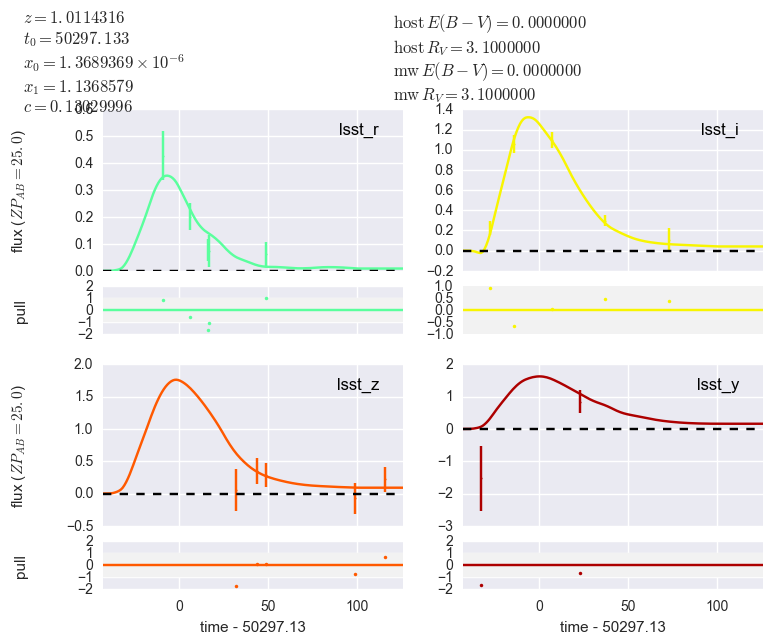

In [27]:
## First failure is for snid=150, let's look
fitSN('150', verbose=True, plot=True)

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

#snFits = Parallel(n_jobs=num_cores, verbose=2)(delayed(fitSN)(id) \
#                                               for id in simdata.headData.index.values)
snFits = {id: fitSN(id) for id in simdata.headData.index.values}